Simple time calculation: 28.55686245854129
numerical time calculation: 28.556862458541257
Difference between analytic and numerical calculation: 3.197442310920451e-14


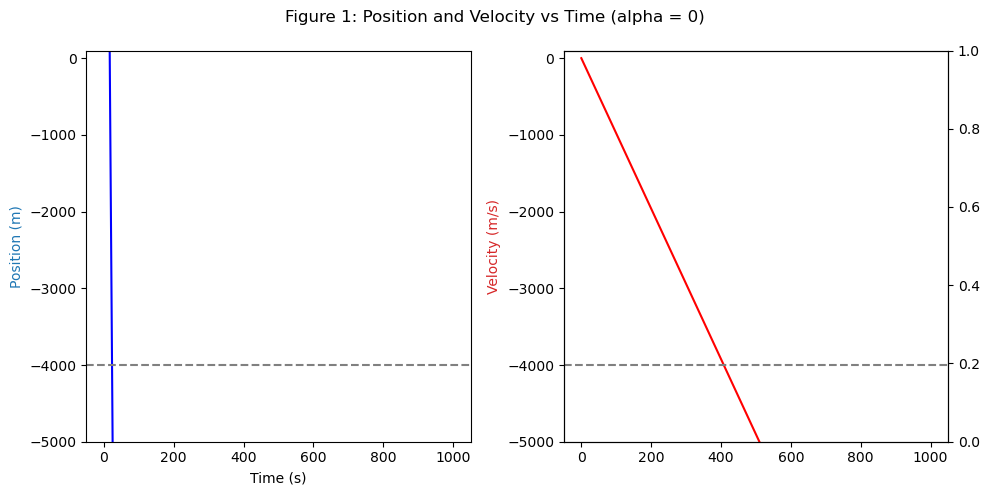

In [100]:
# Christopher Lipscomb
# Lab 2: Mine Crafting
# Part 1: The Ideal Case

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

g = 9.81
y = 4000
alpha = 0
gamma = 2

t_simple = np.sqrt(2 * y / g)
print(f'Simple time calculation: {t_simple}')

def ode(t, z):
    y, v = z
    dydt = v
    dvdt = -g + alpha * np.sign(v) * np.abs(v)**gamma
    return [dydt, dvdt]
    
y0 = [y,0]
t_span = (0,1000)

sol = solve_ivp(ode, t_span, y0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.plot(sol.t, sol.y[0], color = 'blue', label = 'Position (m)')
ax1.axhline(-4000, color='gray', ls='--', label = 'Bottom')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Position (m)', color='tab:blue')
ax1.set_ylim(-5000, 100)

ax2_twin = ax2.twinx()
ax2.plot(sol.t, sol.y[1], color = 'red', label = 'Velocity (m/s)')
ax2.axhline(-4000, color = 'gray', ls='--', label = 'Bottom')
ax2.set_ylabel('Velocity (m/s)', color='tab:red')
ax2.set_ylim(-5000, 100)

fig.suptitle('Figure 1: Position and Velocity vs Time (alpha = 0)')
plt.tight_layout()

def bottom(t, z):
    return z[0]
    
bottom.terminal = True
bottom.direction = -1

sol_event = solve_ivp(ode, t_span, y0, events = bottom)
t_num = sol_event.t_events[0][0]
print(f'numerical time calculation: {t_num}')
print(f'Difference between analytic and numerical calculation: {np.abs(t_simple - t_num)}')



The effect of a variable gravitational acceleration is that it makes the fall time longer. The g function makes the gravitational force weaker as you go further into the mass. However, the effect for only 4 km into the Earth will be quite small.


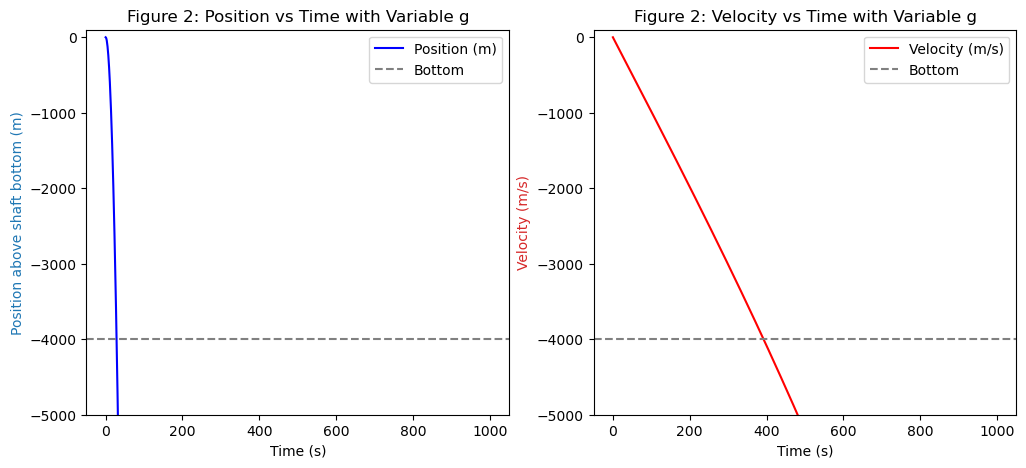

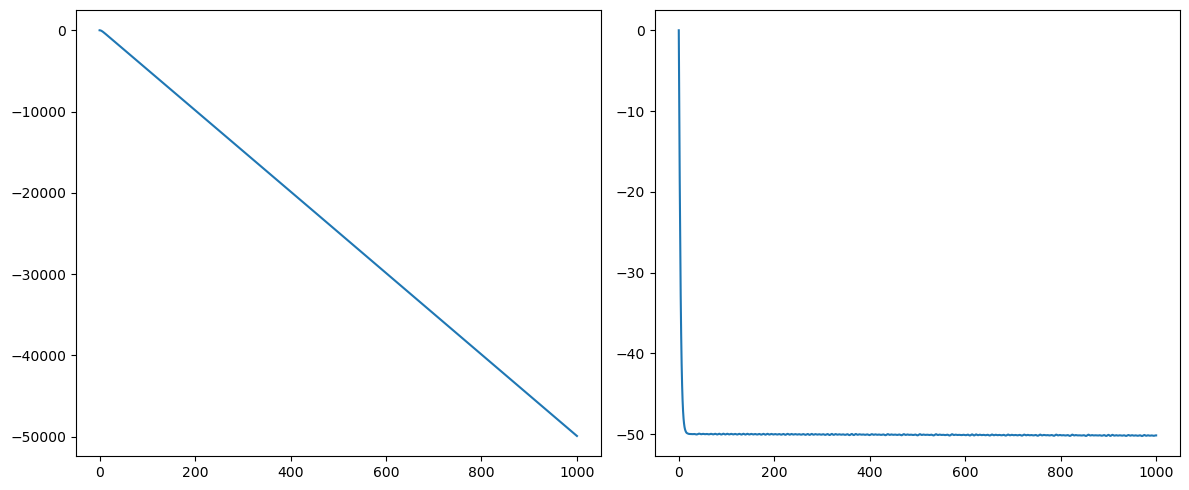

In [103]:
# Part 2: Including Drag and a Variable g

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

g0 = 9.81
Earth_R = 6378100
depth = 4000

def g(y):
    r = Earth_R - y
    return g0 * (r / Earth_R)

def dydt_g(t, z):
    y, v = z
    return [v, -g(y)]

y0 = 0
v0 = 0

t_span = (0,1000)
t_eval = np.linspace(t_span[0], t_span[1], 1000)

def bottom(t, z):
    y, v = z
    return y - depth

bottom.terminal = True
bottom.direction = 1

sol = solve_ivp(dydt_g, t_span, [y0, v0], t_eval=t_eval, events=bottom)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5), sharex = True)

ax1.plot(sol.t, sol.y[0], label = 'Position (m)', color = 'blue')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Position above shaft bottom (m)', color='tab:blue')
ax1.set_title('Figure 2: Position vs Time with Variable g')
ax1.axhline(-4000, color = 'gray', ls='--', label = 'Bottom')
ax1.set_ylim(-5000, 100)
ax1.legend()

ax2.plot(sol.t, sol.y[1], label = 'Velocity (m/s)', color = 'red')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Velocity (m/s)', color='tab:red')
ax2.set_title('Figure 2: Velocity vs Time with Variable g')
ax2.axhline(-4000, color = 'gray', ls='--', label = 'Bottom')
ax2.set_ylim(-5000, 100)
ax2.legend()


t_fall = sol.t_events[0][0] if sol.t_events[0].size > 0 else None

print('The effect of a variable gravitational acceleration is that it makes the fall time longer. The g function makes the gravitational force weaker as you go further into the mass. However, the effect for only 4 km into the Earth will be quite small.')

gamma = 2
v_term = 50
alpha = g0 / (v_term ** gamma)

def dydt_g_drag(t,z):
    y, v = z
    drag = alpha * abs(v)**gamma * np.sign(v)
    return [v, -g(y) - drag]

sol_drag = solve_ivp(dydt_g_drag, t_span, [y0, v0], t_eval=t_eval, events = bottom)

fig, (ax3, ax4) = plt.subplots(1,2, figsize = (12,5), sharex = True)

ax3.plot(sol_drag.t, sol_drag.y[0], label = 'Position with drag (m)')
ax4.plot(sol_drag.t, sol_drag.y[1], label = 'Velocity with drag (m/s)')

fig.tight_layout()

Final position of test mass: 237.9748233491491 m. This test mass will hit the wall before reaching the bottom.

 Final position of test mass with drag: 3.40953923557952 m. This test mass will hit the wall before reaching the bottom, even with drag included.


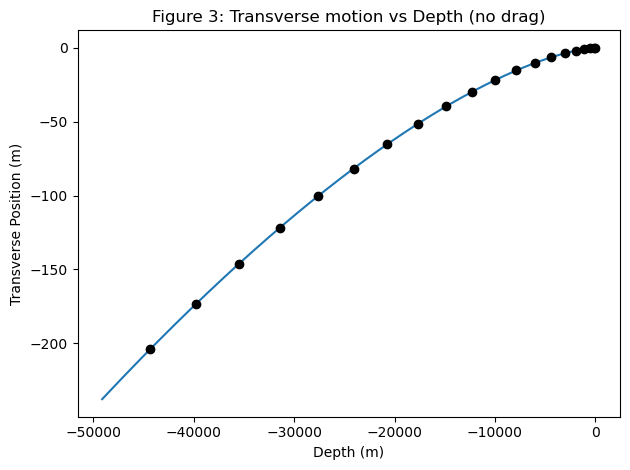

In [106]:
# Part 3: The Coriolis Effect

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

g0 = 9.81
Earth_R = 6378100
Depth = 4000
Earth_Rot = 7.272e-5
v_term = 50
gamma = 2
alpha = g0 / v_term ** gamma

def g(y):
    r = Earth_R - y
    return g0 * (r / Earth_R)

def dydt_Coriolis(t,A):
    x, y, z, vx, vy, vz = A
    ax = 2 * Earth_Rot * vy
    ay = -g(y) - 2 * Earth_Rot * vx
    az = 0
    return [vx, vy, vz, ax, ay, az]

A0 = [0,0,0,0,0,0]

t_span = (0,100)
t_eval = np.linspace(t_span[0], t_span[1], 2000)

def bottom(t,A):
    return A[1] - Depth

bottom.terminal = True
bottom.direction = 1

sol_cor = solve_ivp(dydt_Coriolis, t_span, A0, t_eval=t_eval, events = bottom)

fig, ax = plt.subplots()
ax.plot(sol_cor.y[1], sol_cor.y[0], label = 'Trajectory Without Drag')

for i in range(0, len(sol_cor.t), int(len(sol_cor.t) / 20)):
               ax.plot(sol_cor.y[1][i], sol_cor.y[0][i], 'ko')

ax.set_xlabel("Depth (m)")
ax.set_ylabel('Transverse Position (m)')
ax.set_title("Figure 3: Transverse motion vs Depth (no drag)")

final_pos = sol_cor.y[0][-1]
print(f'Final position of test mass: {np.abs(final_pos)} m. This test mass will hit the wall before reaching the bottom.')

#Adding drag
def dydt_cor_drag(t, A):
    x, y, z, vx, vy, vz = A
    
    v_mag = np.sqrt(vx**2 + vy**2 + vz**2)
    fx_drag = -alpha * v_mag**(gamma - 1) * vx
    fy_drag = -alpha * v_mag**(gamma - 1) * vy
    ax = 2 * Earth_Rot * vy + fx_drag
    ay = -g(y) - 2 * Earth_Rot * vx + fy_drag
    az = 0
    return [vx, vy, vz, ax, ay, az]

sol_cor_drag = solve_ivp(dydt_cor_drag, t_span, A0, t_eval=t_eval, events=bottom)

plt.tight_layout()

final_pos_drag = sol_cor_drag.y[0][-1]
print(f'\n Final position of test mass with drag: {np.abs(final_pos_drag)} m. This test mass will hit the wall before reaching the bottom, even with drag included.')

Time to reach the center of Earth: 1265.6328164082042 s.
Velocity at the center of Earth: 7926.139992718895 m/s.
Time to reach the other side: 1974.633454467604 s.


Orbital speed at the surface: 7905.277129890415 m/s.
Orbital period at the surface: 5069.371199675785 s.
The orbital period is much longer than the "crossing time".


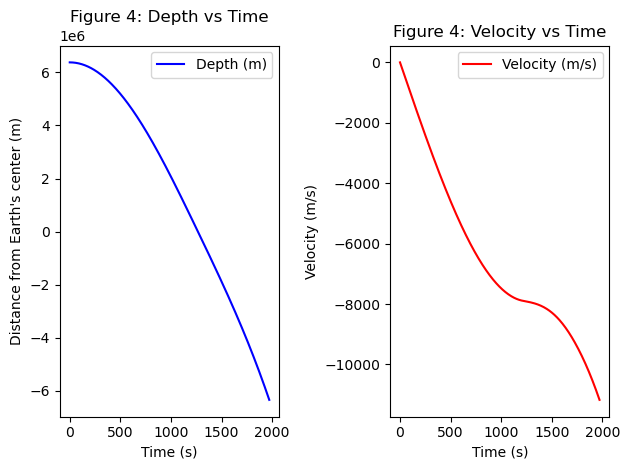

In [107]:
#Part 4: An Infinetely Deep Mine

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

g0 = 9.81
Earth_R = 6378100
Earth_Den = 5515
G = 6.67430e-11
Earth_M = 5.972e24

def gravity(y):
    return g0 * (np.abs(y) / Earth_R)

def dydt_inf(t, z):
    y, v = z
    return [v, -gravity(y)]

z0 = [Earth_R, 0]

t_span = (0,10000)
t_eval = np.linspace(*t_span, 2000)

def other_end(t, z):
    return z[0] + Earth_R

other_end.terminal = True
other_end.direction = -1

sol = solve_ivp(dydt_inf, t_span, z0, t_eval = t_eval, events = other_end)

fig, (ax1, ax2) = plt.subplots(1,2, sharex = True)
ax1.plot(sol.t, sol.y[0], label = "Depth (m)", color = 'blue')
ax1.set_ylabel("Distance from Earth's center (m)")
ax1.set_xlabel("Time (s)")
ax1.set_title("Figure 4: Depth vs Time")
ax1.legend()

ax2.plot(sol.t, sol.y[1], label = "Velocity (m/s)", color = 'red')
ax2.set_ylabel("Velocity (m/s)")
ax2.set_xlabel("Time (s)")
ax2.set_title("Figure 4: Velocity vs Time")
ax2.legend()

plt.tight_layout()

center_time = sol.t[np.argmin(np.abs(sol.y[0]))]
center_speed = np.abs(sol.y[1][np.argmin(np.abs(sol.y[0]))])
crossing_time = sol.t_events[0][0] if sol.t_events[0].size > 0 else None
print(f'Time to reach the center of Earth: {center_time} s.\nVelocity at the center of Earth: {center_speed} m/s.\nTime to reach the other side: {crossing_time} s.')

orbit_speed = np.sqrt(G * Earth_M / Earth_R)
orbit_time = 2 * np.pi * Earth_R / orbit_speed

print(f'\n\nOrbital speed at the surface: {orbit_speed} m/s.\nOrbital period at the surface: {orbit_time} s.\nThe orbital period is much longer than the "crossing time".')

n=0 Time to reach center: 1267.2267781353137 s.
Time to cross: 3801.226778135314 s
n=1 Time to reach center: 851.0672872818217 s.
Time to cross: 5957.067287281821 s
n=2 Time to reach center: 681.7132730728636 s.
Time to cross: 4772.713273072864 s
n=9 Time to reach center: 408.3210731544043 s.
Time to cross: 6000.0 s


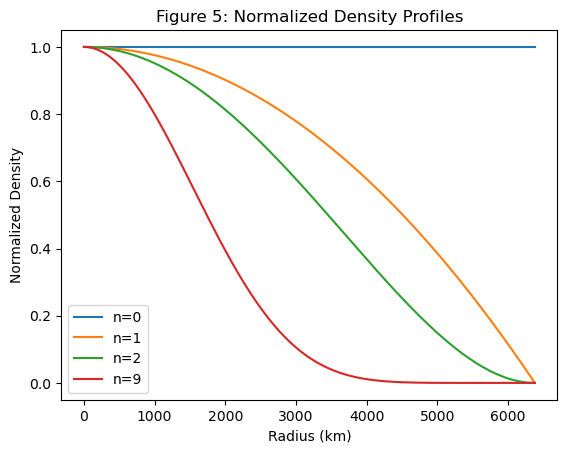

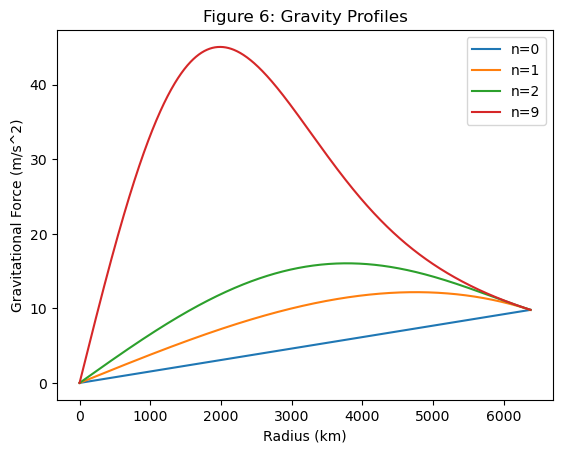

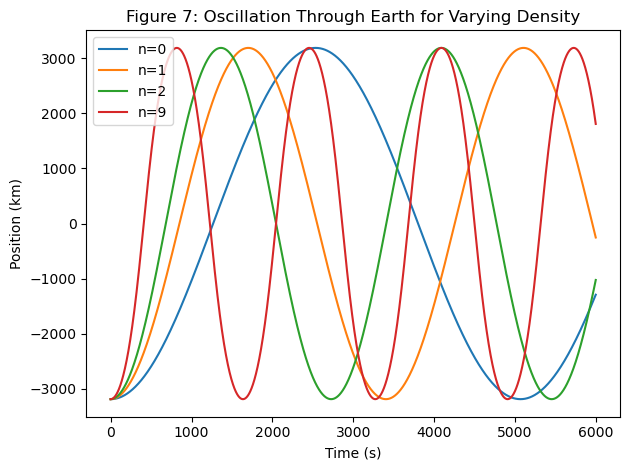

In [109]:
# Part 5: A Non-Uniform Earth
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad, solve_ivp

Earth_R = 6378100
Earth_M = 5.972e24
G = 6.67430e-11

def rho_normal(r,n):
    return (1-(r/Earth_R)**2)**n

r_vals = np.linspace(0, Earth_R, 1000)
n_vals = [0, 1, 2, 9]

fig, ax1 = plt.subplots()
for n in n_vals:
    rho_vals = rho_normal(r_vals, n)
    ax1.plot(r_vals / 1000, rho_vals, label = f'n={n}')

def compute_rho(n):
    int, _ = quad(lambda r : (1 - (r/Earth_R)**2)**n * r**2, 0, Earth_R)
    return Earth_M / (4 * np.pi * int)

def enclosed(r, n, rho_n):
    integrand = lambda b: (1 - (b/Earth_R)**2)**n * b**2
    int, _ = quad(integrand, 0, r)
    return 4 * np.pi * rho_n * int

def grav(r, n, rho_n):
    M = enclosed(r, n, rho_n)
    return G * M / r**2

fig, ax2 = plt.subplots()
for n in n_vals:
    rho_n = compute_rho(n)
    g_vals = np.array([grav(r, n, rho_n) if r > 0 else 0 for r in r_vals])
    ax2.plot(r_vals / 1000, g_vals, label=f'n={n}')

def acceleration(t, z, n, rho_n):
    y, v = z
    r = np.abs(y)
    if r == 0:
        g = 0
    else:
        M = enclosed(r, n, rho_n)
        g = G * M / r**2
    return [v, -np.sign(y) * g]

fig, ax3 = plt.subplots()

for n in n_vals:
    rho_n = compute_rho(n)
    y0, v0 = -Earth_R / 2, 0
    sol = solve_ivp(acceleration, (0, 6000), [y0, v0], args = (n, rho_n), max_step = 1)
    ax3.plot(sol.t, sol.y[0] / 1000, label = f'n={n}')

for n in n_vals:
    rho_n = compute_rho(n)
    sol = solve_ivp(acceleration, (0,6000), [-Earth_R / 2, 0], args = (n, rho_n), max_step = 1)
    y = sol.y[0]
    t = sol.t
    center = np.where(np.diff(np.sign(y)))[0][0]
    t_center = t[center]
    t_cross = t[np.where(np.sign(y) > 0)[0][-1]] if any(y > 0) else None
    print(f'n={n} Time to reach center: {t_center} s.\nTime to cross: {t_cross} s')

ax1.set_xlabel('Radius (km)')
ax1.set_ylabel('Normalized Density')
ax1.set_title('Figure 5: Normalized Density Profiles')

ax2.set_xlabel('Radius (km)')
ax2.set_ylabel('Gravitational Force (m/s^2)')
ax2.set_title('Figure 6: Gravity Profiles')

ax3.set_xlabel('Time (s)')
ax3.set_ylabel('Position (km)')
ax3.set_title('Figure 7: Oscillation Through Earth for Varying Density')

ax1.legend()
ax2.legend()
ax3.legend()
plt.tight_layout()

In [86]:
# Part 6: A Lunar Mine Shaft

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

G = 6.67430e-11
Moon_M = 7.342e22
Moon_R = 1.737e6
Earth_Den = 5515

rho_Moon = ((4/3) * np.pi * Moon_R**3)

def g_moon(r):
    return (4/3) * np.pi * G * rho_Moon * r

def dydt_moon(t, z):
    y, v = z
    g = g_moon(y)
    return [v, -np.sign(y) * g]
    
z0 = [Moon_R, 0]
t_span = (0, 2000)

def center(t, z):
    return z[0]

center.terminal = True
center.direction = -1

sol = solve_ivp(dydt_moon, t_span, z0, events = center, dense_output = True)

time_center = sol.t_events[0][0]
print(f'Time to moon center: {time_center} s')

print(f'Moon density: {Moon_M / rho_Moon} kg/m^3.\nThe Earth is { Earth_Den / (Moon_M / rho_Moon)} times more dense than the earth')

Time to moon center: 2.005287860371511e-05 s
Moon density: 3344.4623826611046 kg/m^3.
The Earth is 1.64899447773482 times more dense than the earth
